In [1]:
import torch
import torchvision
import numpy as np
from torch.utils import data
import matplotlib.pyplot as plt
from torch import nn, optim

In [2]:
model_dense = torchvision.models.densenet121(pretrained=True)

In [3]:
data_transforms = torchvision.transforms.Compose({
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5),(0.5))

})

In [4]:
data_transforms

Compose(
    ToTensor()
    Normalize(mean=0.5, std=0.5)
)

In [5]:
train = torchvision.datasets.MNIST(root="/content/dataset",train=True,transform =data_transforms,download=True)
test = torchvision.datasets.MNIST(root="/content/dataset",train=False,transform =data_transforms,download=True)


In [6]:
train_loader = torch.utils.data.DataLoader(dataset = train,batch_size=128,shuffle=True,num_workers=6,pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset = test,batch_size=128,shuffle=False,num_workers=6,pin_memory=True)

In [7]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/dataset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [8]:
train_loader

In [9]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


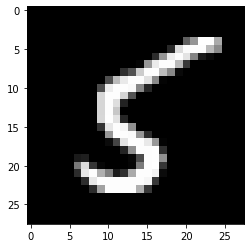

In [10]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

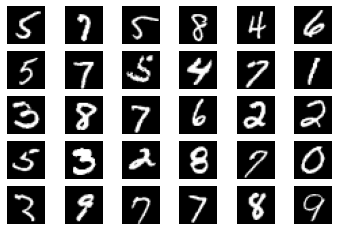

In [11]:
fig = plt.figure()
images_to_display =30
for i in range(0,images_to_display):
  plt.subplot(5,6,i+1)
  plt.axis('off')
  plt.imshow(images[i].numpy().squeeze(),cmap='gray')

In [12]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

model.to("cuda")
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [13]:
criterion = nn.NLLLoss().to("cuda")
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logps = model(images.to("cuda")) #log probabilities
loss = criterion(logps, labels.to("cuda")) #calculate the NLL loss

In [15]:
losses = []

In [16]:
import time
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time.time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images.to("cuda"))
        loss = criterion(output, labels.to("cuda"))
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        losses.append(running_loss/len(train_loader))
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))


Epoch 0 - Training loss: 0.9109356841807172
Epoch 1 - Training loss: 0.34365279746970645
Epoch 2 - Training loss: 0.29161253552447
Epoch 3 - Training loss: 0.255485000974461
Epoch 4 - Training loss: 0.22544332916167245
Epoch 5 - Training loss: 0.20067271288396962
Epoch 6 - Training loss: 0.17824701751981462
Epoch 7 - Training loss: 0.15894307353412673
Epoch 8 - Training loss: 0.14475030560832797
Epoch 9 - Training loss: 0.13236059511362364
Epoch 10 - Training loss: 0.12185944842377197
Epoch 11 - Training loss: 0.11211943453245325
Epoch 12 - Training loss: 0.10388213451673735
Epoch 13 - Training loss: 0.09660959395883816
Epoch 14 - Training loss: 0.08980965143693154


In [17]:
print("\nTraining Time (in minutes) =",(time.time()-time0)/60)


Training Time (in minutes) = 2.5899455984433493


In [18]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 7


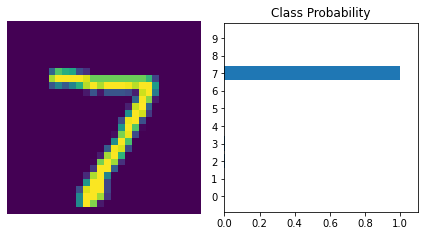

In [19]:
images, labels = next(iter(test_loader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [20]:
correct_count, all_count = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9697


Loss Curve


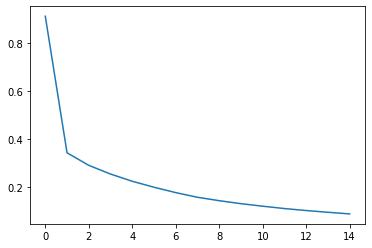

In [23]:
print('Loss Curve')
plt.plot(losses)
plt.show()